# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: [Your-Name?]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [23]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


In [11]:
len(y_train)

50000

### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [17]:
def to_one_hot(y, num_class=10):
  fin = np.zeros((y.shape[0], num_class), dtype = int)
  for i in range(len(y)):
    fin[i][y[i]] = 1

  return fin
    

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0 0 0 0 0 0 1 0 0 0]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [19]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_vec ,random_state=104, test_size=0.2, shuffle=True)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




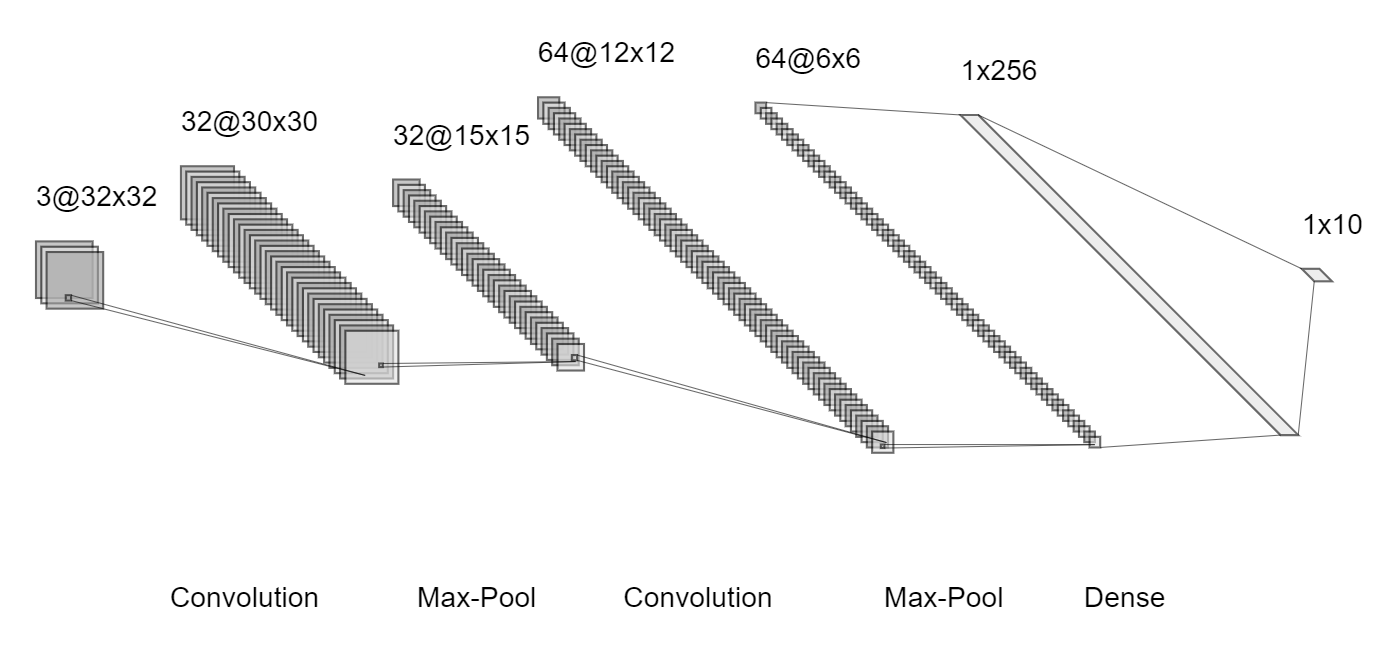

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [43]:
# Build the model
# Model / data parameters
num_classes = 10
input_shape = (32,32,3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation = "relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dense_13 (Dense)            (None, 256)              

In [44]:
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train_vec, epochs=epochs, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 81s 64ms/step - loss: 1.8602 - accuracy: 0.4455 - val_loss: 1.3904 - val_accuracy: 0.5180
Epoch 2/10
1250/1250 [==============================] - 69s 55ms/step - loss: 1.1662 - accuracy: 0.5939 - val_loss: 1.1752 - val_accuracy: 0.5950
Epoch 3/10
1250/1250 [==============================] - 68s 55ms/step - loss: 0.9854 - accuracy: 0.6595 - val_loss: 1.1542 - val_accuracy: 0.6137
Epoch 4/10
1250/1250 [==============================] - 79s 63ms/step - loss: 0.8452 - accuracy: 0.7043 - val_loss: 1.2086 - val_accuracy: 0.6080
Epoch 5/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.6994 - accuracy: 0.7571 - val_loss: 1.2303 - val_accuracy: 0.6208
Epoch 6/10
1250/1250 [==============================] - 78s 62ms/step - loss: 0.5834 - accuracy: 0.7975 - val_loss: 1.3200 - val_accuracy: 0.6239
Epoch 7/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.4925 - accuracy: 0.8283 - val_loss: 1.5579 -

## 3. Plot the training and validation loss curve versus epochs. (5 points)

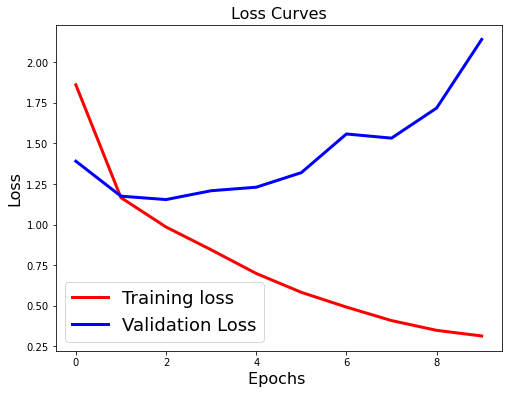

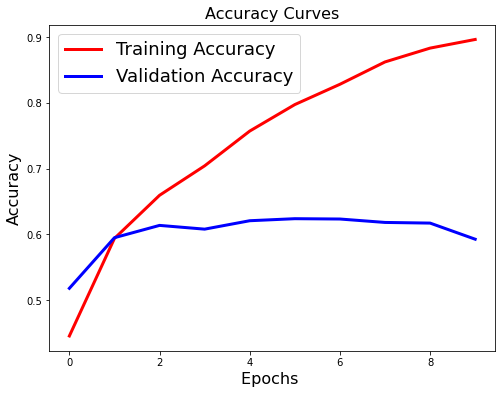

In [47]:
# Train the model and store model parameters/loss values
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves',fontsize=16)
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [45]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [48]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(x_train, y_train_vec, epochs=epochs)

Epoch 1/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.6031 - accuracy: 0.8268
Epoch 2/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.4131 - accuracy: 0.8704
Epoch 3/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.3466 - accuracy: 0.8879
Epoch 4/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.3075 - accuracy: 0.9013
Epoch 5/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.2745 - accuracy: 0.9129
Epoch 6/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.2672 - accuracy: 0.9173
Epoch 7/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.2507 - accuracy: 0.9223
Epoch 8/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.2467 - accuracy: 0.9260
Epoch 9/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.2293 - accuracy: 0.9316
Epoch 10/10
1563/1563 [==============================] - 79s 50m

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [49]:
# Evaluate your model performance (testing accuracy) on testing data.
score = model.evaluate(x_test, y_test_vec, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1] * 100, '%')

Test loss: 3.177097797393799
Test accuracy: 61.97999715805054 %


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

In [51]:
# Build the model
# Model / data parameters
num_classes = 10
input_shape = (32,32,3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.20),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.20),
     
        layers.Flatten(),
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.20),

        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 64)      

In [52]:
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train_vec, epochs=epochs, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 100s 78ms/step - loss: 1.5667 - accuracy: 0.4509 - val_loss: 1.2564 - val_accuracy: 0.5534
Epoch 2/10
1250/1250 [==============================] - 96s 77ms/step - loss: 1.1864 - accuracy: 0.5832 - val_loss: 1.3624 - val_accuracy: 0.5441
Epoch 3/10
1250/1250 [==============================] - 101s 81ms/step - loss: 1.0271 - accuracy: 0.6384 - val_loss: 1.0090 - val_accuracy: 0.6513
Epoch 4/10
1250/1250 [==============================] - 101s 81ms/step - loss: 0.9324 - accuracy: 0.6712 - val_loss: 1.0477 - val_accuracy: 0.6496
Epoch 5/10
1250/1250 [==============================] - 99s 79ms/step - loss: 0.8544 - accuracy: 0.7020 - val_loss: 0.8932 - val_accuracy: 0.6863
Epoch 6/10
1250/1250 [==============================] - 97s 78ms/step - loss: 0.7855 - accuracy: 0.7230 - val_loss: 0.8982 - val_accuracy: 0.7002
Epoch 7/10
1250/1250 [==============================] - 97s 77ms/step - loss: 0.7248 - accuracy: 0.7465 - val_loss: 0.994

In [53]:
score = model.evaluate(x_test, y_test_vec, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1] * 100, '%')

Test loss: 0.9816856384277344
Test accuracy: 69.4100022315979 %
